# overview of llc parcel simulation

In [1]:
import os
#from glob import glob

import numpy as np
import pandas as pd
import xarray as xr

from dask.delayed import delayed
import dask.dataframe as dd

%matplotlib inline
from matplotlib import pyplot as plt

import cartopy.crs as ccrs
import cartopy.feature as cfeature

import mitequinox.plot as pl
import mitequinox.utils as ut
import mitequinox.parcels as pa

import threading

import warnings
warnings.filterwarnings('ignore')

In [2]:
if True:
    from dask.distributed import Client, LocalCluster
    from dask_jobqueue import PBSCluster
    cluster = PBSCluster()
    w = cluster.scale(jobs=4)
    #
    client = Client(cluster)
    client
else:
    from dask.distributed import Client, LocalCluster
    #
    cluster = LocalCluster()
    client = Client(cluster)
    client

---
## load data

In [3]:
root_dir = '/home1/datawork/aponte/parcels/'
run_name = 'global_extra_T365j_dt1j_dij50'

p = pa.parcels_output(root_dir+run_name, parquets=['time', 'trajectory'])
df = p['time']

t_start = df.index.min().compute()
t_end = df.index.max().compute()
delta_t = (t_end - t_start)/pd.Timedelta('1D') # in days

print(t_start, t_end)

df.head()

In [ ]:
# find id's of initial drifter position
df_t0 = df[str(t_start)].compute()

In [ ]:
p['trajectory']

In [5]:
# load llc data
ds = ut.load_data(V=['SST', 'SSU', 'SSV'])
grd = ut.load_grd()[['XC', 'YC', 'XG', 'YG']]
llc = xr.merge([ds, grd])

# subsampling
dij = 8
llc = llc.isel(i=slice(0,None,dij), 
               i_g=slice(0,None,dij), 
               j=slice(0,None,dij), 
               j_g=slice(0,None,dij)
              )

#llc = llc.chunk({'face':-1})

## dev

In [8]:
vplt = llc.SST.isel(time=0).persist()

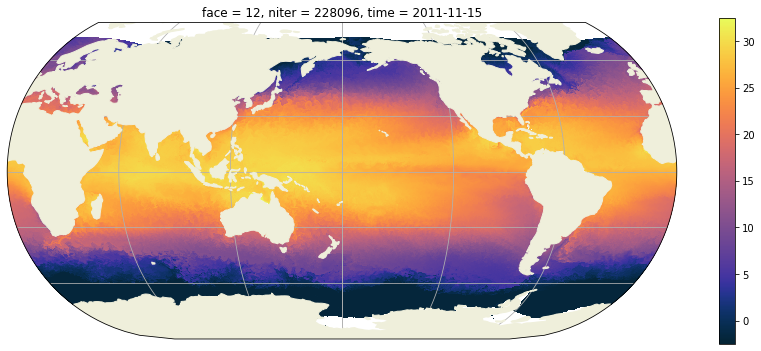

In [14]:
d = pl.plot_pretty(vplt,
                   vmin=-2.5,
                   vmax=32.5,
                   region='global_pacific', 
                   gridlines=False,
                   figsize=(15,6),
                   colorbar=True,
                  )

In [10]:
def plot_llc_parcels(t_start, 
                     t_end,
                     freq=None,
                     del_t=None, 
                     region='global',
                     dij=None,
                     fig_suffix=None, 
                     fig_dir=None,
                     offline=True,
                     overwrite=False,
                    ):
    import dask
    dask.config.set(scheduler='threads')  # overwrite default with threaded scheduler

    
    if freq is None:
        freq = '1H'
    if del_t is None:
        del_t = pd.Timedelta('1d')
    else:
        del_t = pd.Timedelta(del_t)
    if region in ['global', 'global_pacific']:
        dij = 8
        
    if fig_dir is None:
        fig_dir = os.environ['SCRATCH']+'/figs/'
    if fig_suffix is None:
        fig_suffix = ''
    
    t_range = pd.date_range(t_start, t_end, freq=freq)
        
    # llc
    ds = ut.load_data(V=['SST', 'SSU', 'SSV'])
    grd = ut.load_grd()[['XC', 'YC', 'XG', 'YG']]
    llc = xr.merge([ds, grd])
    #llc = llc.sel(time=slice(t_start, t_end))
    llc = llc.sel(time=t_range)    
    llc = llc.isel(i=slice(0,None,dij), 
                   i_g=slice(0,None,dij), 
                   j=slice(0,None,dij), 
                   j_g=slice(0,None,dij),
                  )

    # drifters
    df = dd.read_parquet(run_dir_tmp+'drifters/time')
    df = df.loc[(df.index>t_start-del_t)&(df.index<=t_end)].compute()

    #
    MPL_LOCK = threading.Lock()
    with MPL_LOCK:
        if offline:
            plt.switch_backend('agg')
    
        for t in t_range:
            
            date = t.strftime('%Y-%m-%d_%HH')
            figname = fig_dir+fig_suffix+date+'.png'
            
            if overwrite or not os.path.isfile(figname):

                vplt = llc.SST.sel(time=t).compute()
                d = pl.plot_pretty(vplt,
                                   vmin=-2.5,
                                   vmax=32.5,
                                   region=region, 
                                   gridlines=False,
                                   figsize=(15,6),
                                  )
                fig, ax = d['fig'], d['ax']

                _df = df.loc[(df.index>t-del_t)&(df.index<=t)]
                _df.groupby('trajectory').apply(plot_trajectory, 
                                                ax=ax,
                                                transform=ccrs.PlateCarree(),
                                               )

                d['ax'].set_title(date)

                fig.savefig(figname, dpi=150, bbox_inches = 'tight')
                plt.close(fig)
                

def plot_trajectory(df, ax=None, **kwargs):
    df = df.sort_index()
    if ax is not None:
        ax.plot(df.lon, df.lat, color='k', **kwargs)
    else:
        plt.plot(df.lon, df.lat, color='k', **kwargs)

In [12]:
t_mv_start = pd.Timestamp('2011-11-16 00:00:00')
#t_mv_end = pd.Timestamp('2012-1-1 00:00:00')
t_mv_end = t_end
#t_range = pd.date_range(t_mv_start, t_mv_end, freq='1D')
t_mv_range = pd.date_range(t_mv_start, t_mv_end, freq='10D')

kwargs = dict(freq='1D',
              region='global_pacific',
             )

Nb = len(client.nthreads())
rg = range(0, t_mv_range.size-1)
II = np.array_split(rg,len(rg)/Nb)
print('%d batches to be done'%len(II))

1 batches to be done


In [13]:
#
delayed_fig = delayed(plot_llc_parcels)
#
for I in II:
    print(' batch %d-%d'%(I[0],I[-1]))
    values = [delayed_fig(t_mv_range[i], t_mv_range[i+1], **kwargs) for i in I]
    futures = client.compute(values)
    results = client.gather(futures)

 batch 0-35


In [ ]:
cluster.close()

In [45]:
client.restart()

distributed.scheduler - ERROR - Not all workers responded positively: ['timed out', 'timed out', 'timed out', 'timed out', 'timed out', 'timed out', 'timed out', 'timed out', 'timed out', 'timed out', 'timed out', 'timed out', 'timed out', 'timed out', 'timed out', 'timed out', 'timed out', 'timed out', 'timed out', 'timed out', 'timed out', 'timed out', 'timed out', 'timed out', 'timed out', 'timed out', 'timed out', 'timed out']
NoneType: None


Client Scheduler: tcp://10.148.0.139:59694 Dashboard: http://10.148.0.139:8787/status,Cluster Workers: 28 Cores: 28 Memory: 479.92 GB


In [11]:
for f in futures:
    f.cancel()

In [ ]:
# to create isolated figures:
t_start=pd.Timestamp('2011-12-1 00:00:00')
t_end= t_start + pd.Timedelta('2H')
plot_llc_parcels(t_start, t_end)

## Close cluster

In [31]:
cluster.close()

distributed.client - ERROR - Failed to reconnect to scheduler after 10.00 seconds, closing client
ERROR:asyncio:_GatheringFuture exception was never retrieved
future: <_GatheringFuture finished exception=CancelledError()>
asyncio.exceptions.CancelledError
